<a href="https://colab.research.google.com/github/manargani/speech-emotion-recognition-/blob/main/ser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import random
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
TESS = "/content/drive/MyDrive/Kaggle/tess/TESS Toronto emotional speech set data/"
RAVDESS = "/content/drive/MyDrive/Kaggle/ravdess/audio_speech_actors_01-24/"
SAVEE = "/content/drive/MyDrive/Kaggle/savee/ALL/"
CREMA = "/content/drive/MyDrive/Kaggle/crema/AudioWAV/"

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_angry          96
male_happy          96
male_disgust        96
male_surprise       96
female_sad          96
female_angry        96
female_happy        96
female_disgust      96
female_fear         96
female_surprise     96
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(TESS)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

In [ ]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_angry        60
male_happy        60
male_fear         60
male_disgust      60
male_surprise     60
male_sad          60
Name: labels, dtype: int64

In [ ]:
# merge all data frames together
data_path = pd.concat([Ravdess_df, CREMA_df, TESS_df, SAVEE_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("/content/drive/MyDrive/Kaggle/new_data_path.csv",index=False)
print(len(data_path))
data_path.head()

12162


,labels,source,path
0,male_sad,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
1,male_sad,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
2,male_fear,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
3,male_angry,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
4,male_fear,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...


In [ ]:
# read data frame and make sure that each index has one record not 4
data_path = pd.read_csv('/content/drive/MyDrive/Kaggle/new_data_path.csv')
data_path

,labels,source,path
0,male_sad,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
1,male_sad,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
2,male_fear,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
3,male_angry,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
4,male_fear,RAVDESS,/content/drive/MyDrive/Kaggle/ravdess/audio_sp...
...,...,...,...
12157,male_sad,SAVEE,/content/drive/MyDrive/Kaggle/savee/ALL/KL_sa0...
12158,male_neutral,SAVEE,/content/drive/MyDrive/Kaggle/savee/ALL/KL_n20...
12159,male_surprise,SAVEE,/content/drive/MyDrive/Kaggle/savee/ALL/KL_su0...
12160,male_sad,SAVEE,/content/drive/MyDrive/Kaggle/savee/ALL/KL_sa1...


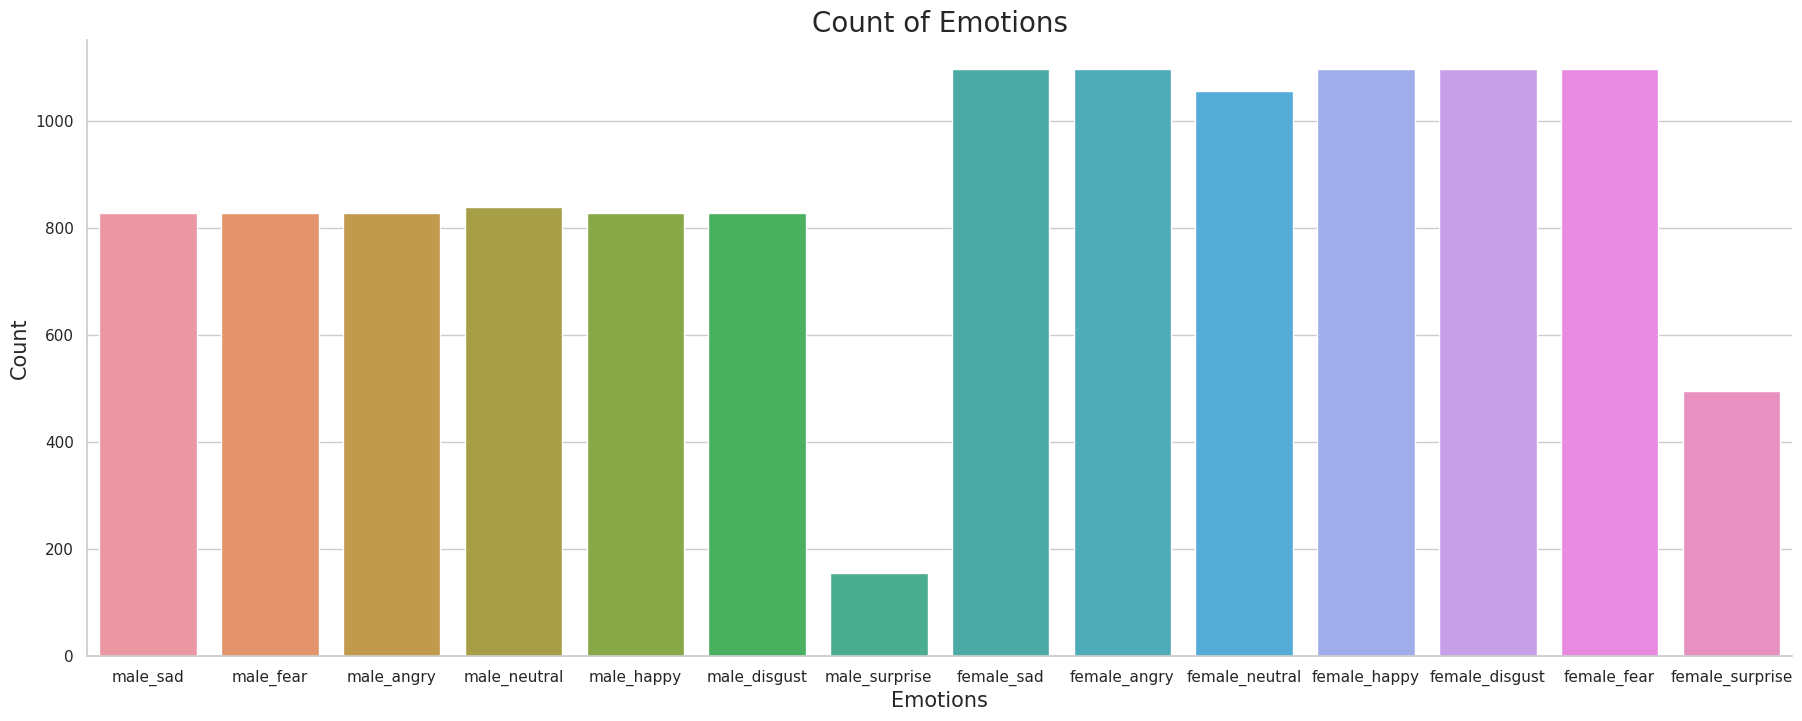

In [ ]:
plt.figure(figsize=(22,8))
sns.countplot(x=data_path.labels)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

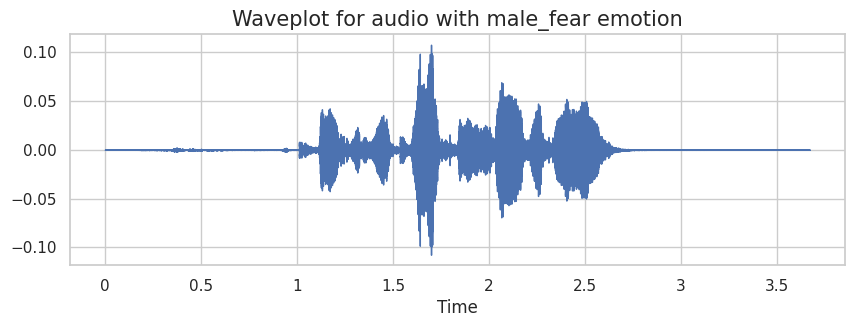

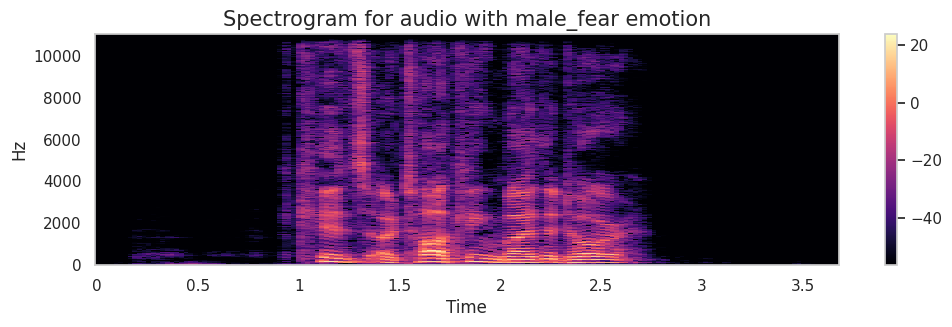

In [ ]:
emotion='male_fear'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

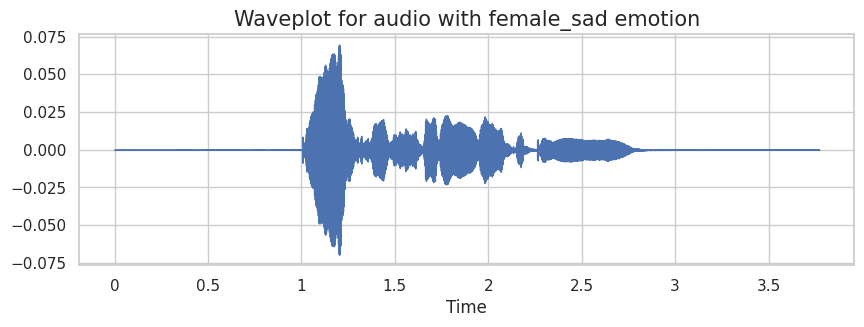

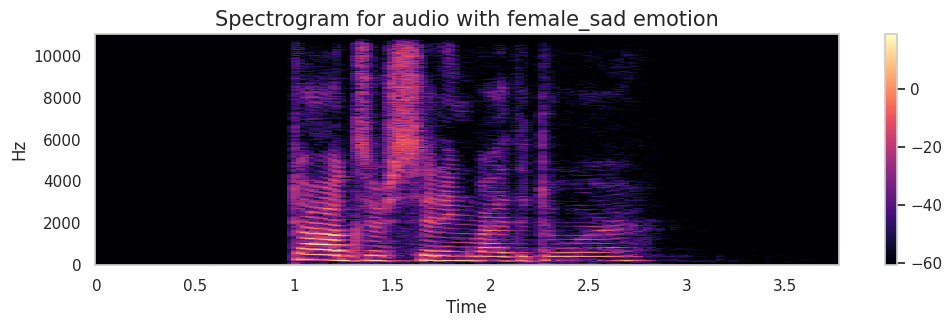

In [ ]:
emotion='female_sad'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)

In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

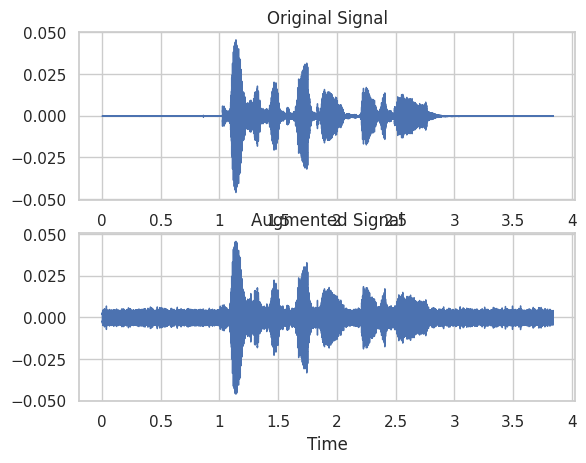

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

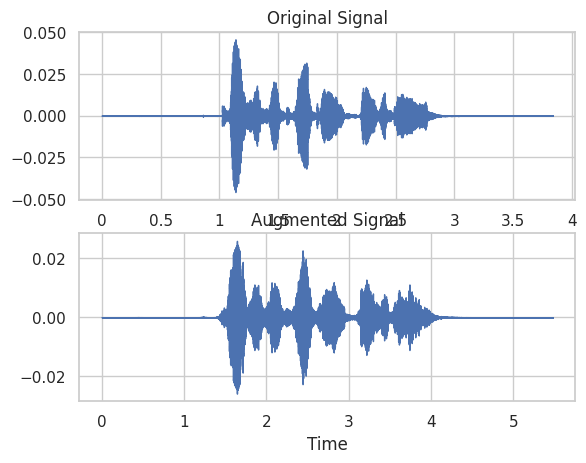

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = stretch(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

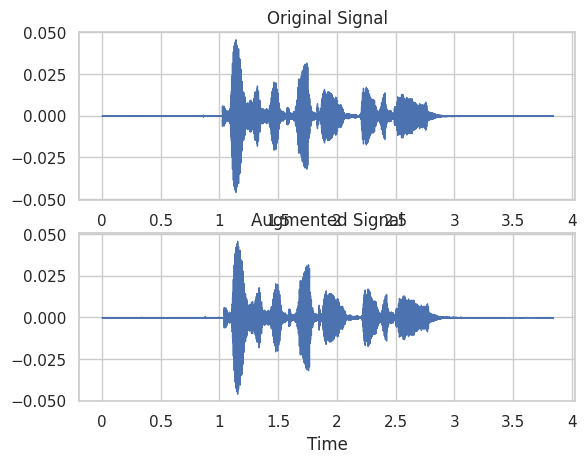

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = shift(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

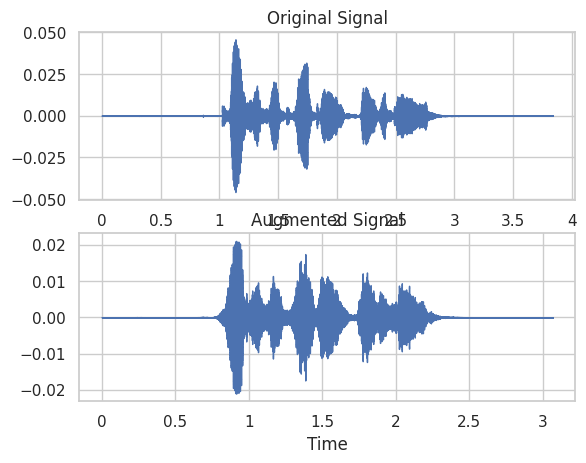

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = higher_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

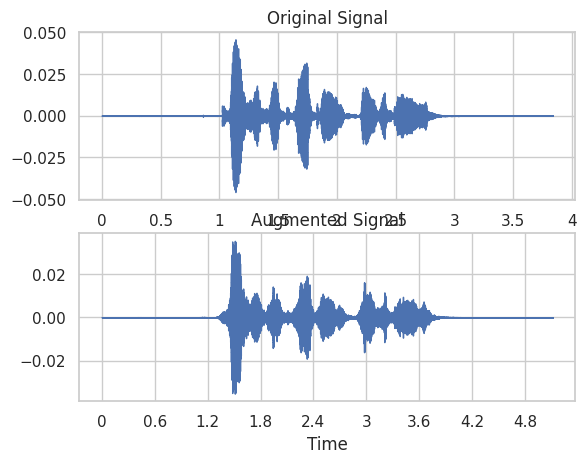

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = lower_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

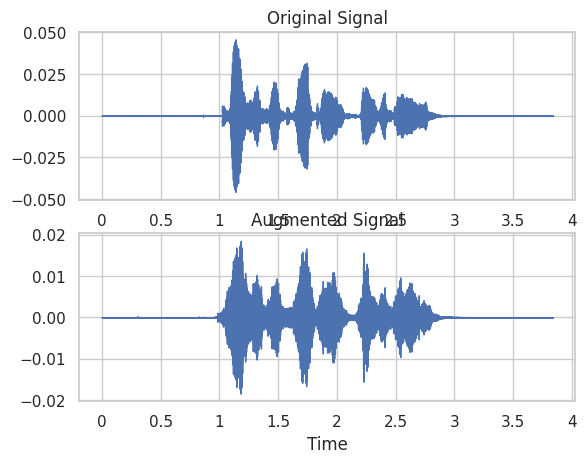

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = pitch(data,22050)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [ ]:
Audio(data, rate=sr)

In [ ]:
Audio(noise(data), rate=sr)

In [ ]:
Audio(shift(data), rate=sr)

In [ ]:
Audio(stretch(data), rate=sr)

In [ ]:
Audio(lower_speed(data), rate=sr)

In [ ]:
Audio(higher_speed(data), rate=sr)

In [ ]:
Audio(pitch(data,22050), rate=sr)

In [ ]:
#sample_rate = 22050

def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:

X, Y = [], []

for path, emotion in tqdm(zip(data_path.path, data_path.labels)):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

12162it [1:47:54,  1.88it/s]


In [ ]:
len(X), len(Y), data_path.path.shape

(85134, 85134, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Kaggle/New_Features.csv', index=False)
print(len(Features))
Features.head()

85134


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-707.943298,70.332085,-3.981637,16.394806,7.665534,-2.153185,-2.060916,-8.838734,-12.730490,-4.445475,...,-2.077875,-2.824750,-1.380177,-1.908650,0.605354,-0.231422,0.740247,-1.467876,0.098661,male_sad
1,-458.475501,24.706217,9.396017,8.649535,3.878766,0.356333,-1.514338,-5.830153,-7.626822,-5.107843,...,-2.119955,-1.724647,-0.755169,-0.586444,-0.106674,0.293921,0.151810,0.442890,-0.022523,male_sad
2,-733.684937,69.465187,-4.774445,16.712610,7.494385,-2.608960,-2.209599,-9.667759,-13.740337,-4.997654,...,-2.152593,-2.737097,-1.357478,-1.770355,0.880542,0.063566,0.895123,-1.523280,-0.074095,male_sad
3,-707.327209,70.193207,-3.967698,16.341932,7.662416,-2.191377,-2.009183,-8.787424,-12.742203,-4.445107,...,-2.080849,-2.807171,-1.390667,-1.892258,0.599671,-0.225567,0.737152,-1.459562,0.130809,male_sad
4,-730.508911,68.863762,-6.570691,16.740339,4.704237,-3.325436,-4.208652,-11.276626,-13.969819,-2.985240,...,-1.036907,-1.580439,0.493599,0.617647,0.762741,-1.132476,-0.969509,-1.321728,0.705717,male_sad


In [ ]:
Features = pd.read_csv('/content/drive/MyDrive/Kaggle/New_Features.csv')
Features

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-707.943298,70.332085,-3.981637,16.394806,7.665534,-2.153185,-2.060916,-8.838734,-12.730490,-4.445475,...,-2.077875,-2.824750,-1.380177,-1.908650,0.605354,-0.231422,0.740247,-1.467876,0.098661,male_sad
1,-458.475501,24.706217,9.396017,8.649535,3.878766,0.356333,-1.514338,-5.830153,-7.626822,-5.107843,...,-2.119955,-1.724647,-0.755169,-0.586444,-0.106674,0.293921,0.151810,0.442890,-0.022523,male_sad
2,-733.684937,69.465187,-4.774445,16.712610,7.494385,-2.608960,-2.209599,-9.667759,-13.740337,-4.997654,...,-2.152593,-2.737097,-1.357478,-1.770355,0.880542,0.063566,0.895123,-1.523280,-0.074095,male_sad
3,-707.327209,70.193207,-3.967698,16.341932,7.662416,-2.191377,-2.009183,-8.787424,-12.742203,-4.445107,...,-2.080849,-2.807171,-1.390667,-1.892258,0.599671,-0.225567,0.737152,-1.459562,0.130809,male_sad
4,-730.508911,68.863762,-6.570691,16.740339,4.704237,-3.325436,-4.208652,-11.276626,-13.969819,-2.985240,...,-1.036907,-1.580439,0.493599,0.617647,0.762741,-1.132476,-0.969509,-1.321728,0.705717,male_sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85129,-569.234131,128.638153,5.829951,35.062042,-2.263885,-9.427647,-10.262020,3.244940,-8.070878,-15.207326,...,4.664910,5.840693,5.859910,3.754756,4.073449,3.703918,4.189067,5.043317,6.493202,male_surprise
85130,-531.097412,119.231285,10.914650,31.657803,1.096371,-8.636891,-9.178338,2.428179,-7.300104,-13.447529,...,4.221083,5.216409,5.324266,3.698465,3.608592,3.107864,3.815243,4.597363,5.726736,male_surprise
85131,-554.491821,122.186150,9.532141,30.745440,-5.756942,-10.719925,-8.912202,1.614572,-12.832878,-13.782478,...,5.624413,5.225645,3.151242,4.447902,4.222444,5.058234,6.114731,5.196578,3.857390,male_surprise
85132,-551.039185,127.975227,7.497323,34.194790,-2.966619,-9.900608,-10.253080,1.875146,-9.386078,-15.623631,...,4.525311,5.466085,6.061797,3.715716,3.585150,3.224010,3.474883,4.799153,6.681324,male_surprise


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
Y[0]


'male_sad'

In [ ]:
encoder = OneHotEncoder()
Y_res = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y_res

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
import pickle
# Enregistrer le transformateur
#with open('/content/drive/MyDrive/Kaggle/encoder.pkl', 'wb') as f:
 #   pickle.dump(encoder, f)

In [ ]:
# Charger le transformateur
with open('/content/drive/MyDrive/Kaggle/encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# Utiliser le transformateur pour effectuer la transformation sur de nouvelles données
X_test_encoded = encoder.transform(X_test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58), (68107, 14), (17027, 58), (17027, 14))

In [ ]:
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((68107, 58, 1), (68107, 14), (17027, 58, 1), (17027, 14))

In [ ]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(14, activation="softmax"))
model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 512)           3072      
                                                                 
 batch_normalization (BatchN  (None, 58, 512)          2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 512)           1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 29, 512)          2048      
 hNormalization)                                                 
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
earlystopping = EarlyStopping(monitor ="val_accuracy",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp,earlystopping])

Epoch 1/50
1065/1065 [==============================] - 33s 17ms/step - loss: 1.4639 - accuracy: 0.4791 - val_loss: 1.9555 - val_accuracy: 0.4364 - lr: 0.0010
Epoch 2/50
1065/1065 [==============================] - 20s 19ms/step - loss: 1.1625 - accuracy: 0.5683 - val_loss: 1.5830 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 3/50
1065/1065 [==============================] - 18s 16ms/step - loss: 1.0415 - accuracy: 0.6117 - val_loss: 1.5248 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 4/50
1065/1065 [==============================] - 18s 17ms/step - loss: 0.9303 - accuracy: 0.6518 - val_loss: 1.1393 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 5/50
1065/1065 [==============================] - 19s 18ms/step - loss: 0.8278 - accuracy: 0.6926 - val_loss: 1.1021 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 6/50
1065/1065 [==============================] - 20s 19ms/step - loss: 0.7342 - accuracy: 0.7290 - val_loss: 0.9014 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 7/50
1065/1065 [========================

533/533 [==============================] - 3s 5ms/step - loss: 0.4371 - accuracy: 0.9303
Accuracy of our model on test data :  93.03 %


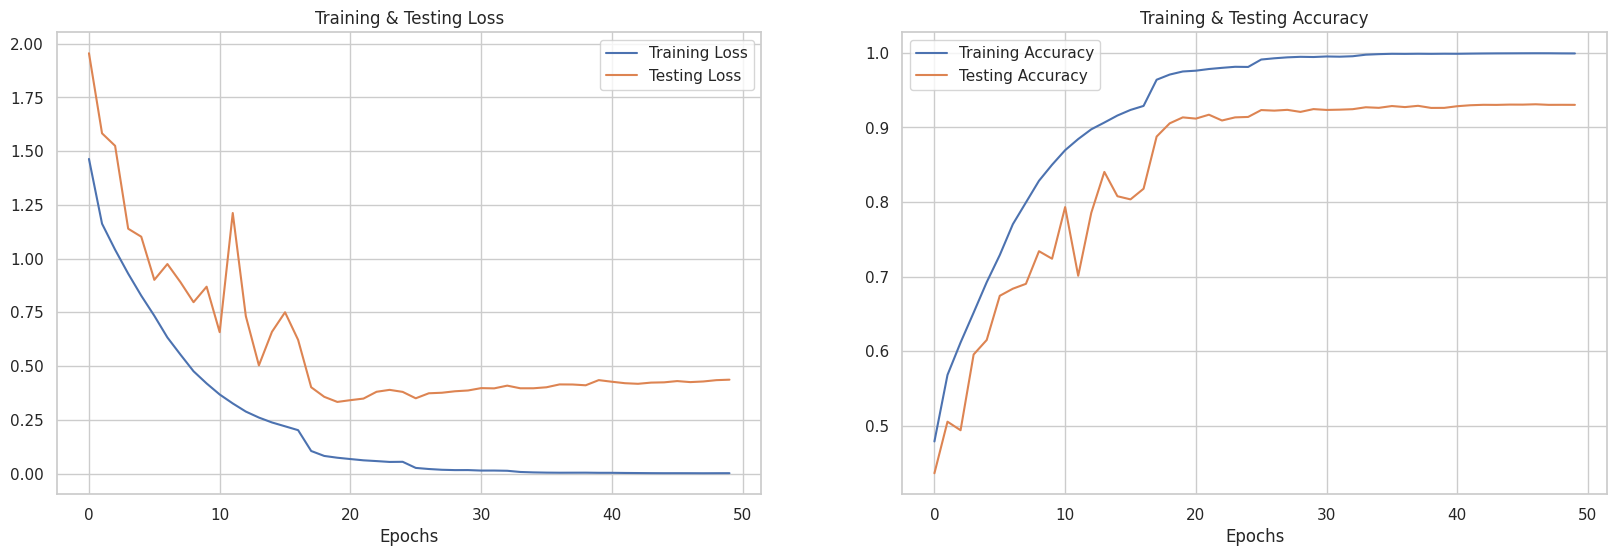

In [ ]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Save model and weights
model_name = 'Emotion_Model_conv1d_gender_93.h5'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Kaggle/model')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("/content/drive/MyDrive/Kaggle/model/Emotion_Model_conv1d_gender_93.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/MyDrive/Kaggle/model/Emotion_Model_conv1d_gender_93.h5 


In [ ]:
# loading json and model architecture
json_file = open('/content/drive/MyDrive/Kaggle/model/Emotion_Model_conv1d_gender_93.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Kaggle/model/Emotion_Model_conv1d_gender_93.h5")
print("Loaded model from disk")

# Keras optimiser
loaded_model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 93.25%


In [ ]:
preds = loaded_model.predict(x_test)
preds.shape

533/533 [==============================] - 2s 3ms/step


(17027, 14)

In [ ]:
# predicting on test data.

y_pred = encoder.inverse_transform(preds)
y_tmp = encoder.inverse_transform(y_test)

In [ ]:
print(y_pred)

[['female_sad']
 ['female_neutral']
 ['male_fear']
 ...
 ['female_disgust']
 ['male_sad']
 ['male_happy']]


In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_sad,female_sad
1,female_neutral,female_neutral
2,male_fear,male_fear
3,female_neutral,female_neutral
4,female_angry,female_angry
...,...,...
17022,male_angry,male_angry
17023,male_disgust,male_happy
17024,female_disgust,female_disgust
17025,male_sad,male_sad


Accuracy of our model on test data based on emotions:  93.0 %


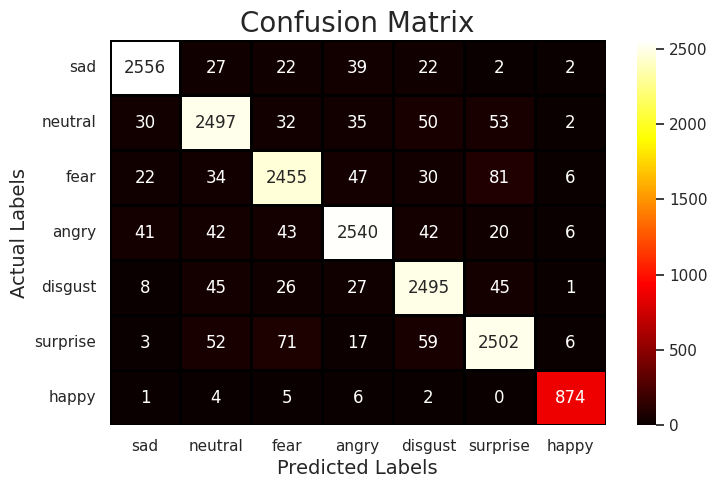

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on emotions: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(modidf['PredictedLabels'].unique())
print(classes)

['sad' 'neutral' 'fear' 'angry' 'disgust' 'surprise' 'happy']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96      2670
     disgust       0.92      0.93      0.92      2699
        fear       0.93      0.92      0.92      2675
       happy       0.94      0.93      0.93      2734
     neutral       0.92      0.94      0.93      2647
         sad       0.93      0.92      0.92      2710
    surprise       0.97      0.98      0.98       892

    accuracy                           0.93     17027
   macro avg       0.94      0.94      0.94     17027
weighted avg       0.93      0.93      0.93     17027



In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_sad,female_sad
1,female_neutral,female_neutral
2,male_fear,male_fear
3,female_neutral,female_neutral
4,female_angry,female_angry
...,...,...
17022,male_angry,male_angry
17023,male_disgust,male_happy
17024,female_disgust,female_disgust
17025,male_sad,male_sad


Accuracy of our model on test data based on gender:  99.0 %


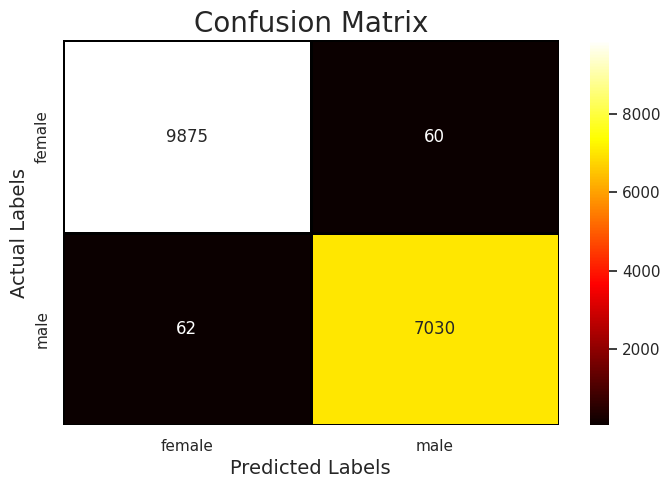

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on gender: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

      female       0.99      0.99      0.99      9935
        male       0.99      0.99      0.99      7092

    accuracy                           0.99     17027
   macro avg       0.99      0.99      0.99     17027
weighted avg       0.99      0.99      0.99     17027

